### Data Loading

In [163]:
import pandas as pd

In [164]:
# df = pd.read_csv('garments_worker_productivity.csv')
df = pd.read_csv('https://raw.githubusercontent.com/vaipos/CS4372_HW1/refs/heads/main/garments_worker_productivity.csv')

### Attribute Analysis

In [165]:
# Attribute Description
df.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

In [166]:
print(f"Number of features: {len(df.columns)}")
print(f"Number of records: {len(df)}")

Number of features: 15
Number of records: 1197


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [168]:
null_info = df.isnull().mean() * 100  
null_info = null_info[null_info > 0].round(2)  

for col, pct in null_info.items():
    print(f"Column {col} has {df[col].isnull().sum()} nulls ({pct:.2f}% of total records)")


Column wip has 506 nulls (42.27% of total records)


In [169]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Columns that are categorical: {cat_cols}")
print(f"Columns that are numerical: {num_cols}")


Columns that are categorical: ['date', 'quarter', 'department', 'day']
Columns that are numerical: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']



Summary for team:
 count    1197.000000
mean        6.426901
std         3.463963
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        12.000000
Name: team, dtype: float64

Summary for targeted_productivity:
 count    1197.000000
mean        0.729632
std         0.097891
min         0.070000
25%         0.700000
50%         0.750000
75%         0.800000
max         0.800000
Name: targeted_productivity, dtype: float64

Summary for smv:
 count    1197.000000
mean       15.062172
std        10.943219
min         2.900000
25%         3.940000
50%        15.260000
75%        24.260000
max        54.560000
Name: smv, dtype: float64

Summary for wip:
 count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

Summary for over_time:
 count     1197.000000
mean      4567.460317
std       3348.823563
min        

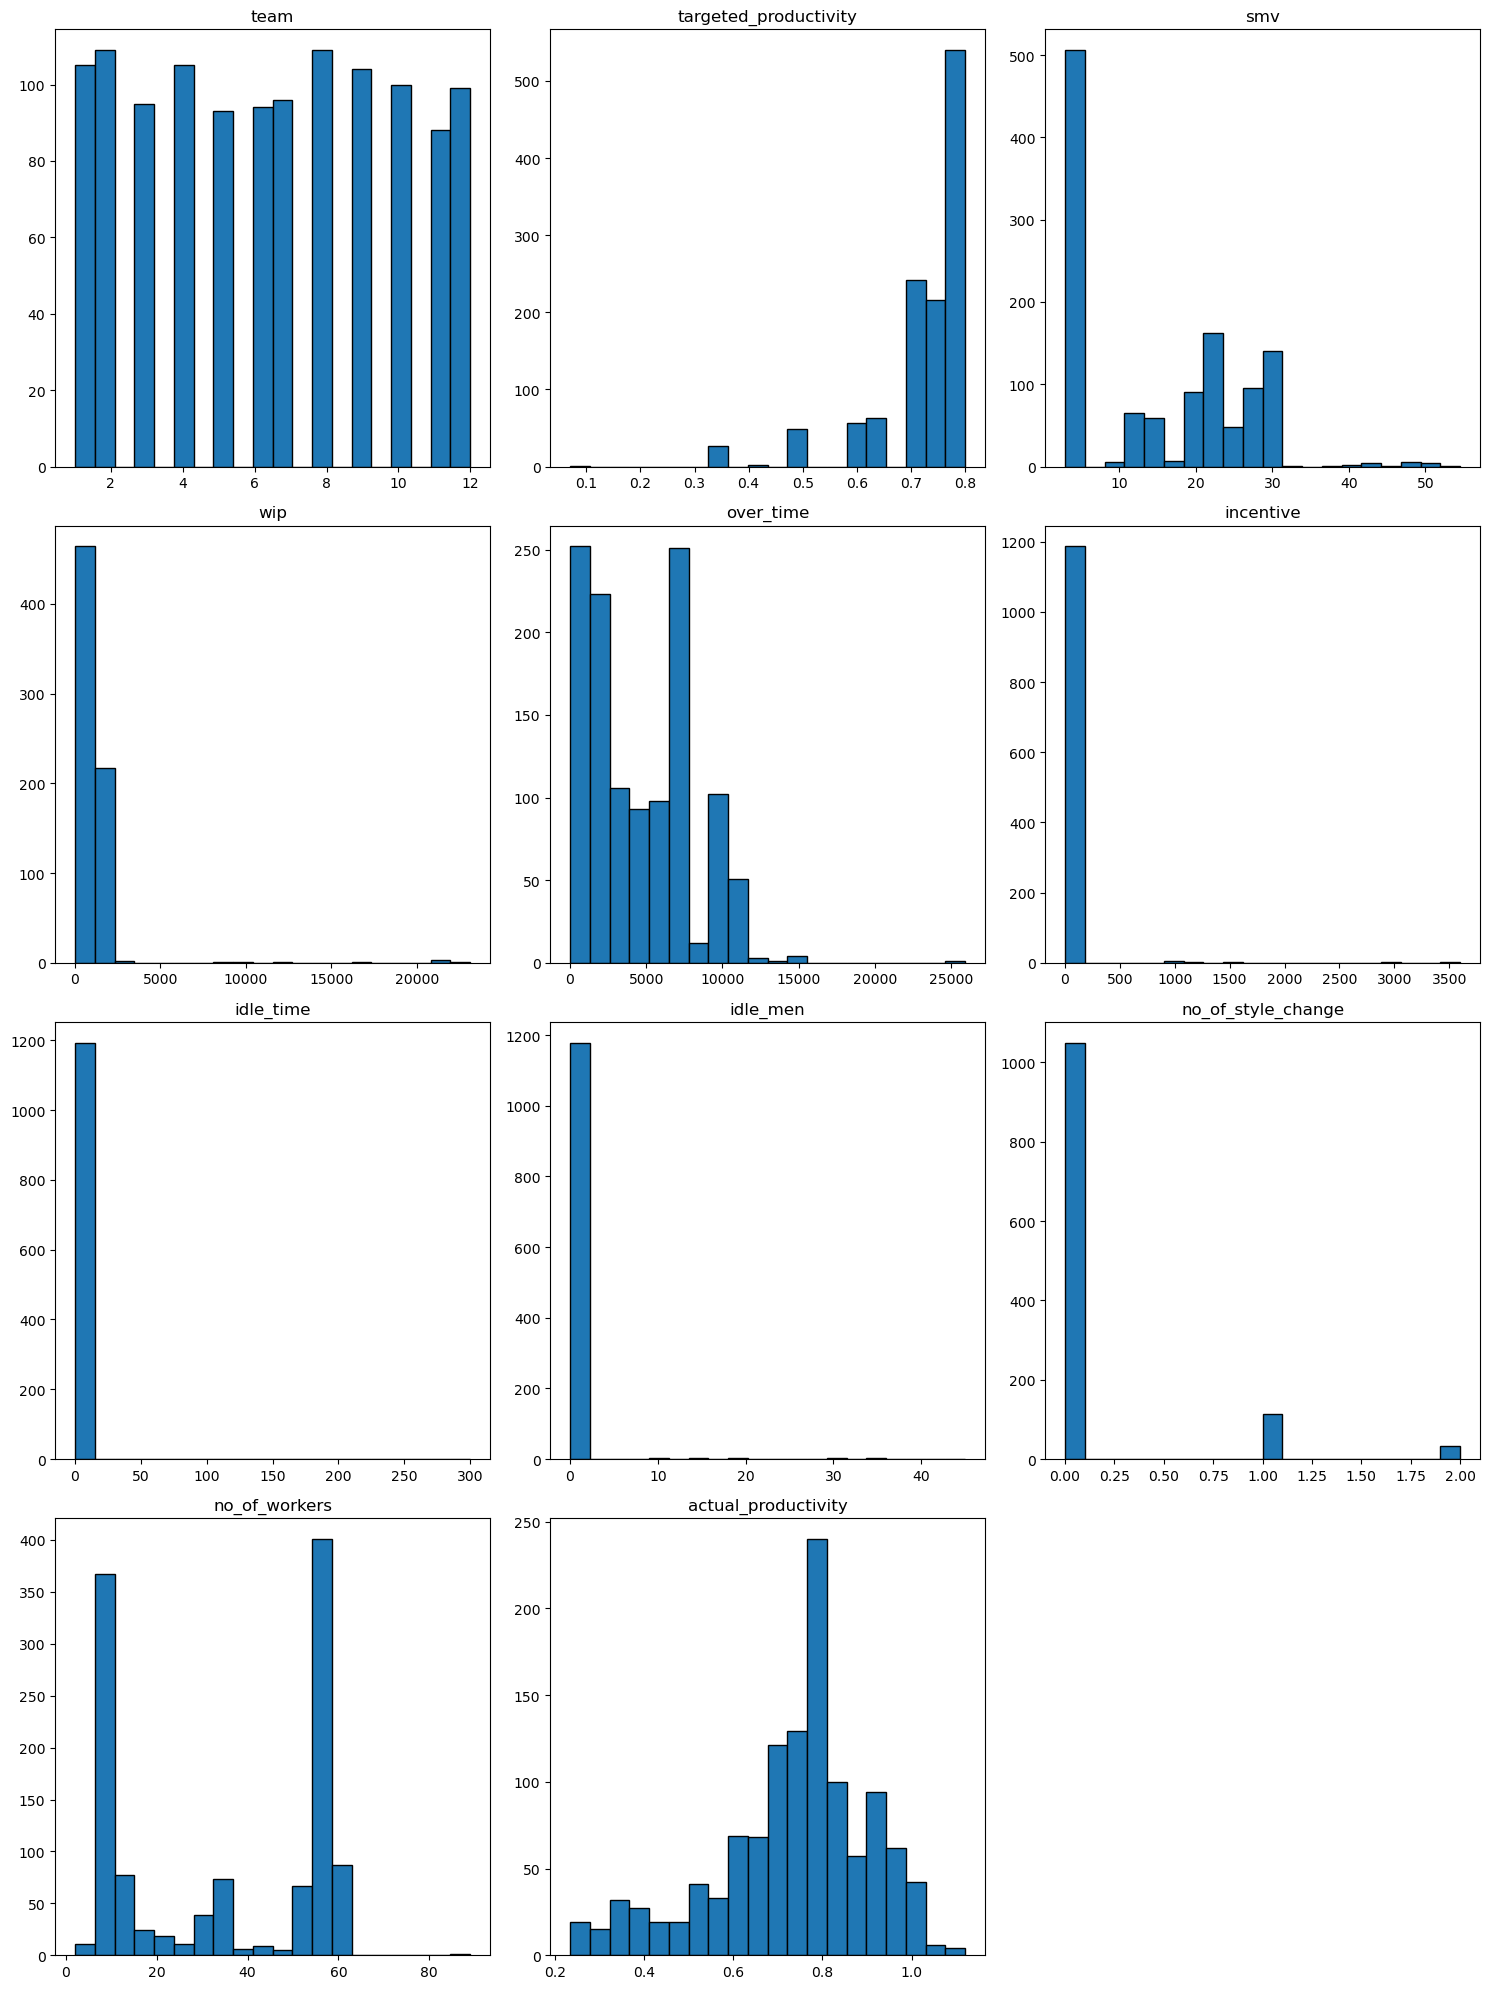

In [170]:
import matplotlib.pyplot as plt
import math

num_plots = len(num_cols)

ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=20, edgecolor="black")
    axes[i].set_title(col)
    print(f"\nSummary for {col}:\n", df[col].describe())

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [171]:
print("Skewness of actual_productivity:", df['actual_productivity'].skew())
print("Kurtosis of actual_productivity:", df['actual_productivity'].kurtosis())


Skewness of actual_productivity: -0.8074917745097576
Kurtosis of actual_productivity: 0.33322734124329134


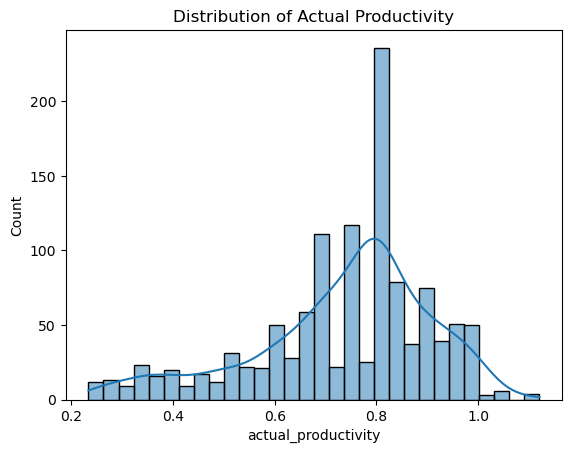

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['actual_productivity'], kde=True, bins=30)
plt.title("Distribution of Actual Productivity")
plt.show()


<Axes: >

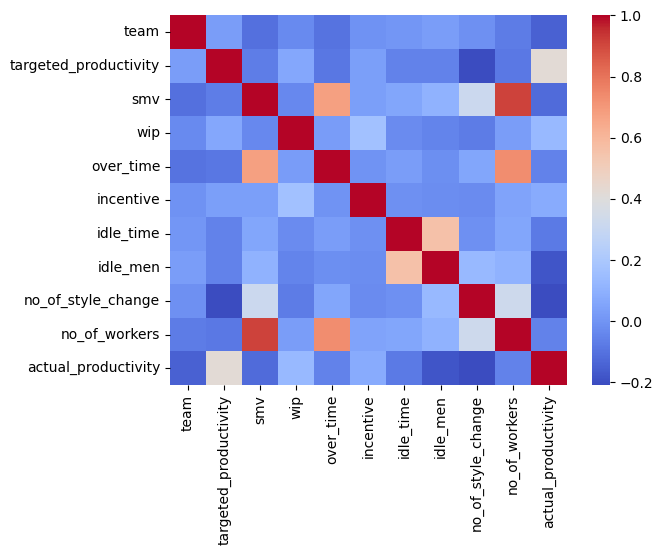

In [173]:
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)


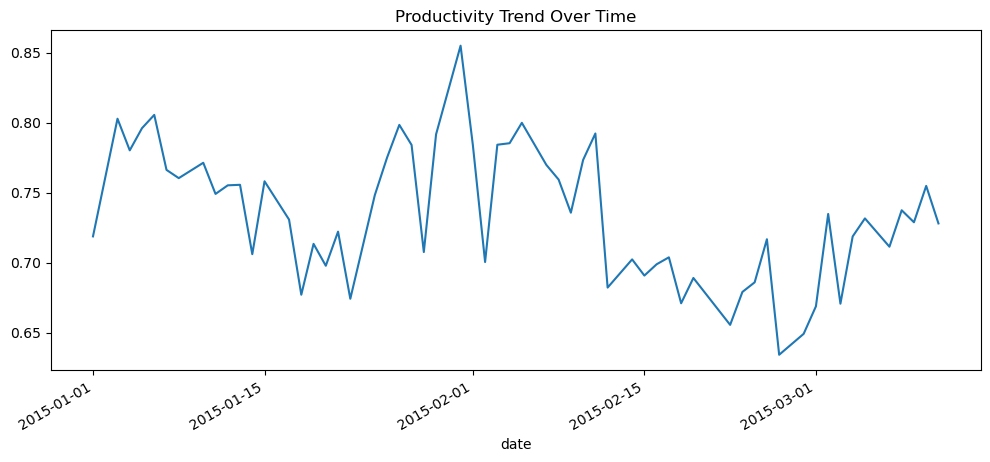

In [174]:
df['date'] = pd.to_datetime(df['date'])
df.groupby('date')['actual_productivity'].mean().plot(figsize=(12,5))
plt.title("Productivity Trend Over Time")
plt.show()


### Data Preprocessing

In [175]:
import numpy as np, pandas as pd, warnings
from itertools import product
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

df5 = df.copy()
df5["date"] = pd.to_datetime(df5["date"], errors="coerce")
df5["month"] = df5["date"].dt.month
df5["weekday"] = df5["date"].dt.weekday
eps = 1e-6
df5["over_time_per_worker"] = df5["over_time"] / (df5["no_of_workers"] + eps)
df5["idle_ratio"] = df5["idle_men"] / (df5["no_of_workers"] + eps)

cat_cols = ["quarter","department","day","team"]
num_linear = ["wip","over_time","incentive","idle_time","idle_men","no_of_style_change","month","weekday"]
num_poly = ["targeted_productivity","smv","no_of_workers","over_time_per_worker","idle_ratio"]
target = "actual_productivity"

X = df5[cat_cols + num_linear + num_poly]
y = df5[target]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
num_linear_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

num_poly_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("pre_scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("post_scale", StandardScaler())
])

cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

pre = ColumnTransformer([
    ("num_lin", num_linear_tf, num_linear),
    ("num_poly", num_poly_tf, num_poly),
    ("cat", cat_tf, cat_cols),
])

X_tr_pre = pre.fit_transform(X_tr)
X_te_pre = pre.transform(X_te)

### Model Development

#### Model 1 Build

* Listed Hyperparameter Combination Testing

In [177]:
import numpy as np, pandas as pd
from itertools import product
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

grid = {
    "loss": ["huber","squared_error"],
    "penalty": ["elasticnet","l2"],
    "alpha": [1e-6,3e-6,1e-5,3e-5,1e-4,3e-4,1e-3],
    "l1_ratio": [0.2,0.5,0.8],
    "learning_rate": ["optimal"],
    "eta0": [1e-3],
    "power_t": [0.25],
    "max_iter": [8000],
    "epsilon": [0.01,0.03],
    "average": [True]
}

rows = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)
keys, vals = zip(*grid.items())
for combo in product(*vals):
    p = dict(zip(keys, combo))
    if p["penalty"] != "elasticnet" and p["l1_ratio"] != 0.2:
        continue
    if p["loss"] != "huber" and p["epsilon"] != 0.01:
        continue
    cv_r2, cv_rmse, cv_mae, cv_tr = [], [], [], []
    for tr_idx, va_idx in kf.split(X_tr_pre):
        Xtr, Xva = X_tr_pre[tr_idx], X_tr_pre[va_idx]
        ytr, yva = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
        reg = SGDRegressor(random_state=42, early_stopping=True, validation_fraction=0.15,
                           n_iter_no_change=12, tol=1e-3, **p)
        model = TransformedTargetRegressor(regressor=reg, transformer=StandardScaler())
        model.fit(Xtr, ytr)
        ytrp = model.predict(Xtr); yvap = model.predict(Xva)
        cv_r2.append(r2_score(yva, yvap))
        cv_rmse.append(rmse(yva, yvap))
        cv_mae.append(mean_absolute_error(yva, yvap))
        cv_tr.append(r2_score(ytr, ytrp))
    rows.append({**p,
                 "cv_mean_R2": float(np.mean(cv_r2)),
                 "cv_std_R2": float(np.std(cv_r2)),
                 "cv_mean_RMSE": float(np.mean(cv_rmse)),
                 "cv_mean_MAE": float(np.mean(cv_mae)),
                 "cv_mean_train_R2": float(np.mean(cv_tr))})



In [178]:
res = pd.DataFrame(rows).sort_values(by=["cv_mean_R2","cv_mean_RMSE"], ascending=[False, True]).reset_index(drop=True)
res.head(10)[["loss","penalty","alpha","l1_ratio","learning_rate","eta0","power_t","max_iter","epsilon","average","cv_mean_R2","cv_mean_RMSE","cv_mean_MAE","cv_mean_train_R2"]]

,loss,penalty,alpha,l1_ratio,learning_rate,eta0,power_t,max_iter,epsilon,average,cv_mean_R2,cv_mean_RMSE,cv_mean_MAE,cv_mean_train_R2
0,huber,l2,0.001000,0.2,optimal,0.001,0.25,8000,0.03,True,0.276617,0.150238,0.102032,0.327510
1,huber,l2,0.001000,0.2,optimal,0.001,0.25,8000,0.01,True,0.276013,0.150352,0.100391,0.309896
2,huber,l2,0.000300,0.2,optimal,0.001,0.25,8000,0.01,True,0.267517,0.151179,0.102124,0.310599
3,huber,l2,0.000100,0.2,optimal,0.001,0.25,8000,0.01,True,0.240366,0.154012,0.104566,0.338670
4,huber,l2,0.000300,0.2,optimal,0.001,0.25,8000,0.03,True,0.144443,0.162751,0.107401,0.276602
5,huber,l2,0.000030,0.2,optimal,0.001,0.25,8000,0.01,True,0.104060,0.166857,0.108852,0.237457
6,huber,l2,0.000010,0.2,optimal,0.001,0.25,8000,0.01,True,-0.564422,0.214962,0.119158,0.084219
7,huber,l2,0.000100,0.2,optimal,0.001,0.25,8000,0.03,True,-0.570771,0.214789,0.118828,0.106423
8,huber,l2,0.000030,0.2,optimal,0.001,0.25,8000,0.03,True,-0.881311,0.236306,0.126156,-0.305429
9,huber,elasticnet,0.000003,0.2,optimal,0.001,0.25,8000,0.01,True,-1.270511,0.257107,0.142471,-0.784872


In [187]:
best = res.iloc[0].to_dict()
final_reg = SGDRegressor(
    loss=best["loss"], penalty=best["penalty"], alpha=float(best["alpha"]),
    l1_ratio=float(best["l1_ratio"]), learning_rate=best["learning_rate"],
    eta0=float(best["eta0"]), power_t=float(best["power_t"]),
    max_iter=int(best["max_iter"]), epsilon=float(best["epsilon"]),
    average=bool(best["average"]), random_state=42,
    early_stopping=True, validation_fraction=0.15, n_iter_no_change=12, tol=1e-3
)
final_model = TransformedTargetRegressor(regressor=final_reg, transformer=StandardScaler())
final_model.fit(X_tr_pre, y_tr)

ytr_pred = final_model.predict(X_tr_pre)
yte_pred = final_model.predict(X_te_pre)

In [188]:
# --- Hyperparameters Table ---
best_hyperparams = {k: best[k] for k in ["loss","penalty","alpha","l1_ratio",
                                         "learning_rate","eta0","power_t","max_iter",
                                         "epsilon","average"]}

hyperparams_df = pd.DataFrame({
    'Hyperparameter': list(best_hyperparams.keys()),
    'Value': list(best_hyperparams.values())
})

# Display hyperparameters
display(hyperparams_df)

,Hyperparameter,Value
0,loss,huber
1,penalty,l2
2,alpha,0.001
3,l1_ratio,0.2
4,learning_rate,optimal
5,eta0,0.001
6,power_t,0.25
7,max_iter,8000
8,epsilon,0.03
9,average,True


In [189]:
# --- Metrics Table ---
train_r2 = r2_score(y_tr, ytr_pred)
test_r2 = r2_score(y_te, yte_pred)
test_rmse = np.sqrt(((y_te - yte_pred)**2).mean())
test_mae = mean_absolute_error(y_te, yte_pred)

metrics_df = pd.DataFrame({
    'Metric': ['Train R2', 'Test R2', 'Test RMSE', 'Test MAE'],
    'Value': [train_r2, test_r2, test_rmse, test_mae]
})

# Display metrics
display(metrics_df)

,Metric,Value
0,Train R2,0.319270
1,Test R2,0.148343
2,Test RMSE,0.150378
3,Test MAE,0.097242


#### Model 2 Build

* Listed Hyperparameter Combination Testing

In [182]:
# Model Import and build
import statsmodels.api as sm

# Prepare data (using the same train/test split as Model 1)
X_tr_sm = sm.add_constant(X_tr_pre)
X_te_sm = sm.add_constant(X_te_pre)

In [183]:
# Fit Ordinary Least Squares (OLS) regression
ols_model = sm.OLS(y_tr, X_tr_sm).fit()

print(ols_model.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.412
Model:                             OLS   Adj. R-squared:                  0.385
Method:                  Least Squares   F-statistic:                     15.28
Date:                 Sun, 21 Sep 2025   Prob (F-statistic):           6.07e-79
Time:                         20:18:12   Log-Likelihood:                 553.30
No. Observations:                  957   AIC:                            -1021.
Df Residuals:                      914   BIC:                            -811.5
Df Model:                           42                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6026      0.015     39.98

In [190]:
# Predictions
ytr_pred_sm = ols_model.predict(X_tr_sm)
yte_pred_sm = ols_model.predict(X_te_sm)

# Compute metrics for the second model (OLS)
train_r2_sm = r2_score(y_tr, ytr_pred_sm)
test_r2_sm = r2_score(y_te, yte_pred_sm)
test_rmse_sm = np.sqrt(((y_te - yte_pred_sm)**2).mean())
test_mae_sm = mean_absolute_error(y_te, yte_pred_sm)

# Create metrics DataFrame
metrics_sm_df = pd.DataFrame({
    'Metric': ['Train R2', 'Test R2', 'Test RMSE', 'Test MAE'],
    'Value': [train_r2_sm, test_r2_sm, test_rmse_sm, test_mae_sm]
})

# Display table
metrics_sm_df

,Metric,Value
0,Train R2,0.412495
1,Test R2,0.248361
2,Test RMSE,0.141272
3,Test MAE,0.104969


### Results for Model 1 and Model 2

In [185]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def scaled_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Normalized RMSE relative to range of actual_productivity
    nrmse = rmse / (y_true.max() - y_true.min())

    # Accuracy relative to mean actual productivity
    accuracy = 1 - (mae / y_true.mean())

    return {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "nRMSE": nrmse,
        "MAPE%": mape,
        "Accuracy%": accuracy * 100
    }

# Collect results into a dictionary of dictionaries
results = {
    "Model1_SGD_Train": scaled_metrics(y_tr, ytr_pred),
    "Model1_SGD_Test":  scaled_metrics(y_te, yte_pred),
    "Model2_OLS_Train": scaled_metrics(y_tr, ytr_pred_sm),
    "Model2_OLS_Test":  scaled_metrics(y_te, yte_pred_sm)
}


# Convert to DataFrame
metrics_df = pd.DataFrame(results).T

# Display neatly
metrics_df.round(4)



,R2,RMSE,MAE,nRMSE,MAPE%,Accuracy%
Model1_SGD_Train,0.3193,0.1461,0.0978,0.1648,18.3434,86.6499
Model1_SGD_Test,0.1483,0.1504,0.0972,0.1966,17.2017,86.9567
Model2_OLS_Train,0.4125,0.1357,0.0976,0.1531,17.2692,86.6816
Model2_OLS_Test,0.2484,0.1413,0.1050,0.1847,17.4861,85.9202


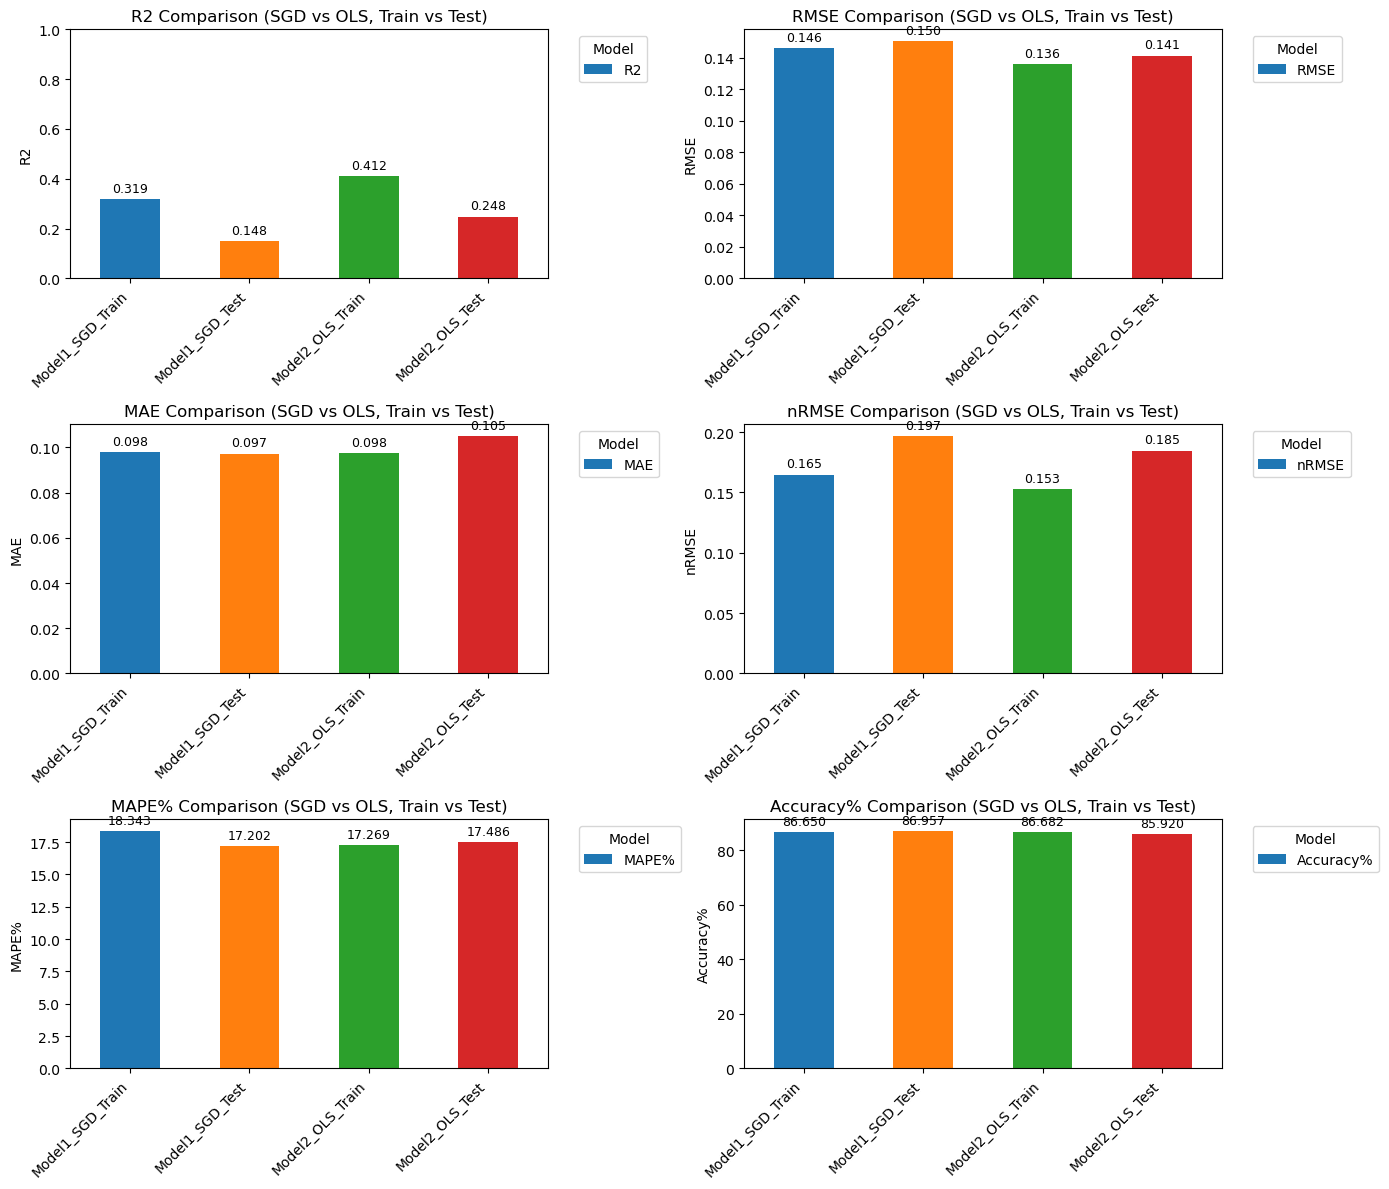

In [186]:
import matplotlib.pyplot as plt

# Transpose so metrics are rows
metrics_df_plot = metrics_df.T
metrics = metrics_df_plot.index.tolist()  # e.g., ['MAE','RMSE','R2', ...]

# Define 3x2 layout
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    bars = metrics_df_plot.loc[metric].plot(kind='bar', ax=axes[i], color=plt.cm.tab10.colors)
    axes[i].set_title(f"{metric} Comparison (SGD vs OLS, Train vs Test)", fontsize=12)
    axes[i].set_ylabel(metric, fontsize=10)
    axes[i].set_xticks(range(len(metrics_df_plot.columns)))
    axes[i].set_xticklabels(metrics_df_plot.columns, rotation=45, ha='right')
    
    # Special handling for R²
    if metric.lower() == 'r2':
        axes[i].set_ylim(0, 1)
    
    axes[i].legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add numeric labels on top of each bar
    for bar in axes[i].patches:
        height = bar.get_height()
        axes[i].annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
